In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('talk')

import matplotlib.dates as mdates
sns.set_palette(sns.color_palette(plt.cm.tab20.colors))

# Load COVID-19 data

In [2]:
covid_df = pd.read_csv(
#     '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
    'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
)
covid_df['Country/Region'] = covid_df['Country/Region'].map(lambda x: x.strip('*'))
print(covid_df.shape)
date_cols = covid_df.columns[4:].tolist()
covid_df.head()

(452, 58)


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,...,48,50,50,50,53,59,70,75,82,114.0
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,...,420,461,502,511,581,639,639,701,773,773.0
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,130,138,150,150,160,178,178,200,212,226.0
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1.0
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,...,83,93,99,117,129,149,149,197,238,428.0


In [3]:
covid_df['region_name'] = covid_df\
    .apply(lambda row: row['Country/Region'] if pd.isnull(row['Province/State']) or row['Province/State'] == row['Country/Region']\
           else '{}, {}'.format(row['Province/State'], row['Country/Region']),
           axis=1)

In [4]:
covid_df = covid_df.set_index('region_name')

In [5]:
# correct US state date prior to 3/9/20
us_states = pd.read_excel('data/US_state_abbr.xlsx').set_index('states')
date_cols_before_39 = date_cols[:date_cols.index('3/9/20')+1]

for state_name, abbr in zip(us_states.index, us_states['abbr']):
    locations_in_this_state = covid_df['Province/State'].fillna('NULL').str.endswith(', %s' % abbr)

    covid_df.loc['%s, US' % state_name, date_cols_before_39] = \
        covid_df.loc[locations_in_this_state, date_cols_before_39].sum(axis=0)

In [9]:
# covid_df[date_cols] = covid_df[date_cols].astype(np.int)

In [10]:
covid_df.loc[['Washington, US', 'New York, US', 'California, US']]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20
region_name,,,,,,,,,,,,,,,,,,,,,
"Washington, US",Washington,US,47.4009,-121.4905,1.0,1.0,1.0,1.0,1.0,1.0,...,78.0,102.0,122.0,122.0,267.0,366.0,442.0,568.0,572.0,642.0
"New York, US",New York,US,42.1657,-74.9481,0.0,0.0,0.0,0.0,0.0,0.0,...,31.0,76.0,106.0,142.0,173.0,220.0,328.0,421.0,525.0,729.0
"California, US",California,US,36.1162,-119.6816,0.0,0.0,0.0,0.0,2.0,2.0,...,59.0,81.0,95.0,101.0,144.0,177.0,221.0,282.0,340.0,406.0


In [11]:
# covid_df['Province/State'].replace({'Washington, D.C.': 'District of Columbia'}, inplace=True)

## Load region-level external data

In [12]:
region_population_df_us = pd.read_csv('data/population/US_by_states/nst-est2019-alldata.csv')
# keep state-level only
region_population_df_us = region_population_df_us.iloc[5:] 
print(region_population_df_us.shape)

(52, 151)


In [13]:
region_area_df_us = pd.read_excel('data/area/US_area_by_states.xlsx')
print(region_area_df_us.shape)

(52, 2)


In [14]:
us_meta_df = pd.concat([
    region_population_df_us.set_index('NAME')[['POPESTIMATE2018']].rename(columns={'POPESTIMATE2018': 'population'}),
    region_area_df_us.set_index('States').rename(columns={'total_area_sqkm': 'area'}),
], axis=1)
us_meta_df.index = us_meta_df.index.map(lambda s: '%s, US' % s)
print(us_meta_df.shape)
us_meta_df.head()

(52, 2)


,population,area
"Alabama, US",4887681,135767
"Alaska, US",735139,1723337
"Arizona, US",7158024,295234
"Arkansas, US",3009733,137732
"California, US",39461588,423967


In [15]:
region_population_df_cn = pd.read_excel('data/population/China_population_by_province.xlsx')
print(region_population_df_cn.shape)

(33, 2)


In [16]:
region_area_df_cn = pd.read_excel('data/area/China_area_by_province.xlsx')
print(region_area_df_cn.shape)

(33, 2)


In [17]:
cn_meta_df = pd.concat([
    region_population_df_cn.set_index('Province')[['population_2017']].rename(columns={'population_2017': 'population'}),
    region_area_df_cn.set_index('Province')[['area_sqkm']].rename(columns={'area_sqkm': 'area'}),
], axis=1, sort=False)
cn_meta_df.index = cn_meta_df.index.map(lambda s: '%s, China' % s)
print(cn_meta_df.shape)
cn_meta_df.head()

(33, 2)


,population,area
"Guangdong, China",111690000,179700.0
"Shandong, China",100060000,157100.0
"Henan, China",95590000,167000.0
"Sichuan, China",83020000,486100.0
"Jiangsu, China",80290000,102600.0


In [18]:
region_meta_df = pd.concat([us_meta_df, cn_meta_df])
region_meta_df.shape

(85, 2)

In [19]:
shared_regions = set(covid_df.index.dropna()) & set(region_meta_df.index)
len(shared_regions)

85

In [20]:
set(region_meta_df.index) - set(covid_df.index.dropna())

set()

## Load country-level external data

In [21]:
world_meta_df = pd.read_csv('data/world_meta_df.csv').set_index('Country Name')
print(world_meta_df.shape)
world_meta_df.head()

(265, 4)


,population,area,hospital_beds_per_1k,estimated_hospital_beds
Country Name,,,,
Aruba,105845.0,180.0,NaN,NaN
Afghanistan,37172386.0,652860.0,0.5,18586.1930
Angola,30809762.0,1246700.0,0.8,24647.8096
Albania,2866376.0,28750.0,2.9,8312.4904
Andorra,77006.0,470.0,2.5,192.5150


In [22]:
# concat country-level and region-level external data
meta_df = pd.concat([region_meta_df, world_meta_df[['population', 'area']]])
print(meta_df.shape)

(350, 2)


In [23]:
shared_regions = set(meta_df.index) & set(covid_df.index.dropna())
len(shared_regions)

215

In [24]:
covid_df = covid_df.loc[shared_regions]
covid_df.shape

(215, 58)

In [25]:
covid_df = covid_df.sort_values(date_cols[-1], ascending=False)
covid_df.head(20)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20
region_name,,,,,,,,,,,,,,,,,,,,,
"Hubei, China",Hubei,China,30.9756,112.2707,444.0,444.0,549.0,761.0,1058.0,1423.0,...,67592.0,67666.0,67707.0,67743.0,67760.0,67773.0,67781.0,67786.0,67790.0,67794.0
Italy,NaN,Italy,43.0000,12.0000,0.0,0.0,0.0,0.0,0.0,0.0,...,4636.0,5883.0,7375.0,9172.0,10149.0,12462.0,12462.0,17660.0,21157.0,21157.0
Iran,NaN,Iran,32.0000,53.0000,0.0,0.0,0.0,0.0,0.0,0.0,...,4747.0,5823.0,6566.0,7161.0,8042.0,9000.0,10075.0,11364.0,12729.0,13938.0
"Korea, South",NaN,"Korea, South",36.0000,128.0000,1.0,1.0,2.0,2.0,3.0,4.0,...,6593.0,7041.0,7314.0,7478.0,7513.0,7755.0,7869.0,7979.0,8086.0,8162.0
Spain,NaN,Spain,40.0000,-4.0000,0.0,0.0,0.0,0.0,0.0,0.0,...,400.0,500.0,673.0,1073.0,1695.0,2277.0,2277.0,5232.0,6391.0,7798.0
Germany,NaN,Germany,51.0000,9.0000,0.0,0.0,0.0,0.0,0.0,1.0,...,670.0,799.0,1040.0,1176.0,1457.0,1908.0,2078.0,3675.0,4585.0,5426.0
France,France,France,46.2276,2.2137,0.0,0.0,2.0,3.0,3.0,3.0,...,653.0,949.0,1126.0,1209.0,1784.0,2281.0,2281.0,3661.0,4469.0,4499.0
Switzerland,NaN,Switzerland,46.8182,8.2275,0.0,0.0,0.0,0.0,0.0,0.0,...,214.0,268.0,337.0,374.0,491.0,652.0,652.0,1139.0,1359.0,2200.0
"Guangdong, China",Guangdong,China,23.3417,113.4244,26.0,32.0,53.0,78.0,111.0,151.0,...,1352.0,1352.0,1352.0,1352.0,1353.0,1356.0,1356.0,1356.0,1356.0,1360.0


In [26]:
top_regions = covid_df.head(20).index

In [27]:
# melt
covid_df_m = covid_df\
    .reset_index()\
    .melt(value_vars=date_cols, 
                           id_vars='region_name', 
                           value_name='n_confirmed',
                          var_name='date')
covid_df_m['date'] = pd.to_datetime(covid_df_m['date'])
covid_df_m.head()

,region_name,date,n_confirmed
0,"Hubei, China",2020-01-22,444.0
1,Italy,2020-01-22,0.0
2,Iran,2020-01-22,0.0
3,"Korea, South",2020-01-22,1.0
4,Spain,2020-01-22,0.0


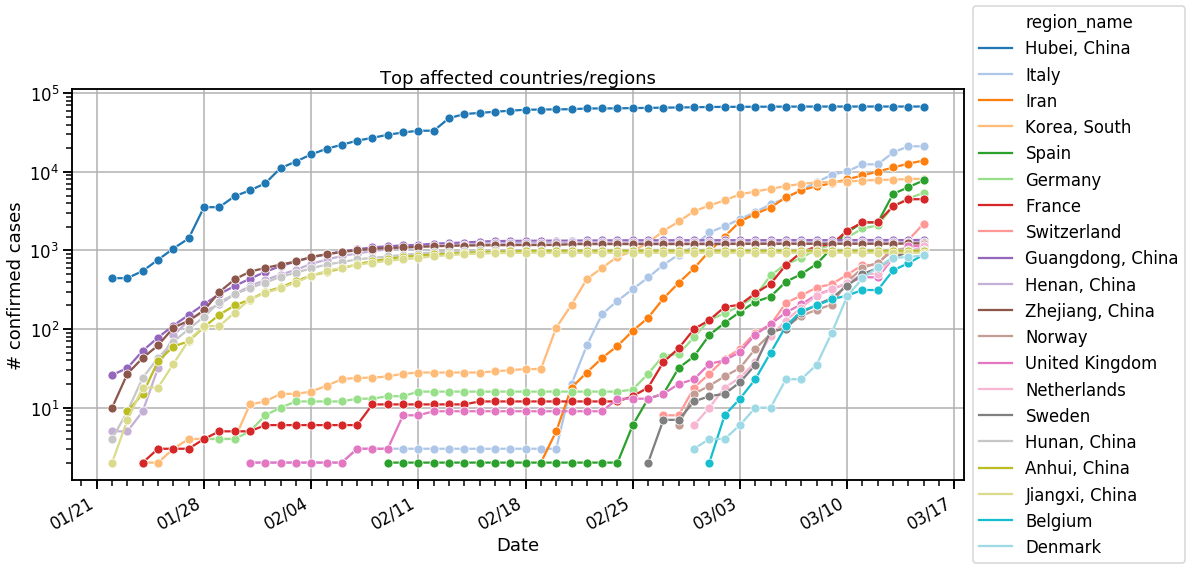

In [31]:
fig, ax = plt.subplots(figsize=(16, 8))
ax = sns.lineplot(x='date', 
                  y='n_confirmed',
                  hue='region_name',
                  hue_order=top_regions,
                  data=covid_df_m.loc[covid_df_m['region_name'].isin(top_regions)]\
                      .query('n_confirmed > 1'),
                  marker='o',
                  ax=ax
                 )

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_yscale('log')
ax.set(title='Top affected countries/regions', 
       ylabel='# confirmed cases', 
       xlabel='Date')



weeks = mdates.WeekdayLocator()
days = mdates.DayLocator()
week_fmt = mdates.DateFormatter('%m/%d')

# format the ticks
ax.xaxis.set_major_locator(weeks)
ax.xaxis.set_major_formatter(week_fmt)
ax.xaxis.set_minor_locator(days)

ax.grid(True)

fig.autofmt_xdate()
fig.savefig('figs/top_regions.png', 
           bbox_extra_artists=(lgd,), bbox_inches='tight')

# Curve fitting

In [32]:
import statsmodels.api as sm
from scipy.optimize import curve_fit

In [33]:
f_exponetial = lambda t, a, b: np.exp(a+b*t)

def fit_exponential(y, y_min=50, n_data_points=None):
    '''Fit exponential function to curve
    '''
    mask = y >= y_min
    
    y = y[mask]
    x = np.arange(len(y))
    
    if n_data_points:
        # fit at most the first n days
        right_idx = min(n_data_points, len(x))
        x = x[:right_idx]
        y = y[:right_idx]
    
    X = sm.add_constant(x)
    model = sm.OLS(np.log(y),X)
    results = model.fit()

    a, b = results.params
    p_a, p_b = results.pvalues
    return (a, b), (p_a, p_b)

In [34]:
y_min = 50
n_data_points = [None, # use all data points for fitting
                 30, # use the first 30 days for fitting
                 20,
                 10
                ] 

fitted_exp_params_df = []

for region in covid_df.index:    
    n_confirmed = covid_df.loc[region, date_cols].astype(np.int)
    if (n_confirmed > y_min).sum() >= 5: # the cumulative cases are at least 100 for 5 days 
        
        n_data_points_avail = (n_confirmed >= y_min).sum()
        for n in n_data_points:
            if (n is not None and n < n_data_points_avail) or n is None:
                # only fit the first n days if there are more data points avail 
                (a, b), (p_a, p_b) = fit_exponential(n_confirmed.values, y_min=y_min, n_data_points=n)
                if n is None:
                    n = n_data_points_avail
                fitted_exp_params_df.append({
                    'region': region, 
                    'a': a,
                    'b': b,
                    'pval_a': p_a,
                    'pval_b': p_b,
                    'y_min': y_min,
                    'n_data_points': n
                })
            
fitted_exp_params_df = pd.DataFrame(fitted_exp_params_df)
print(fitted_exp_params_df.shape)

(182, 7)


In [35]:
fitted_exp_params_df.sort_values('b', ascending=False).head(20)

,region,a,b,pval_a,pval_b,y_min,n_data_points
9,Iran,4.127887,0.446743,3.585339e-13,2.865340e-11,50,10
113,Finland,3.987610,0.416961,3.225617e-04,1.677624e-02,50,5
112,Portugal,3.920986,0.389980,7.547837e-05,4.922012e-03,50,5
6,Italy,4.560953,0.360902,1.966763e-10,1.781857e-07,50,10
12,"Korea, South",5.087837,0.346502,4.190580e-10,1.187386e-06,50,10
55,Denmark,5.069608,0.345670,7.364108e-06,5.428331e-03,50,7
119,Slovenia,4.133223,0.340190,2.200599e-05,2.583294e-03,50,5
13,Spain,4.369196,0.329765,8.243325e-18,3.933245e-15,50,15
3,"Hubei, China",5.809082,0.328536,5.603930e-11,7.102555e-07,50,10
18,France,4.156706,0.321494,1.041087e-11,1.180145e-08,50,10


In [36]:
# get the max `b` among all the fits for each country
fitted_exp_params_df_max = fitted_exp_params_df\
    .sort_values('b', ascending=False)\
    .groupby('region')\
    .first()\
    .sort_values('b', ascending=False)

print(fitted_exp_params_df_max.shape)
fitted_exp_params_df_max.head(20)

(67, 6)


,a,b,pval_a,pval_b,y_min,n_data_points
region,,,,,,
Iran,4.127887,0.446743,3.585339e-13,2.865340e-11,50,10
Finland,3.987610,0.416961,3.225617e-04,1.677624e-02,50,5
Portugal,3.920986,0.389980,7.547837e-05,4.922012e-03,50,5
Italy,4.560953,0.360902,1.966763e-10,1.781857e-07,50,10
"Korea, South",5.087837,0.346502,4.190580e-10,1.187386e-06,50,10
Denmark,5.069608,0.345670,7.364108e-06,5.428331e-03,50,7
Slovenia,4.133223,0.340190,2.200599e-05,2.583294e-03,50,5
Spain,4.369196,0.329765,8.243325e-18,3.933245e-15,50,15
"Hubei, China",5.809082,0.328536,5.603930e-11,7.102555e-07,50,10


In [37]:
fitted_exp_params_df_max.loc[fitted_exp_params_df_max.index.str.endswith(', US')]

,a,b,pval_a,pval_b,y_min,n_data_points
region,,,,,,
"New York, US",4.354828,0.277616,1.166239e-13,4.873005e-10,50,9
"Washington, US",4.105219,0.267966,2.763262e-10,1.100497e-06,50,10
"California, US",3.897013,0.213726,4.193574e-14,7.582363e-10,50,10
"Massachusetts, US",4.503307,0.093643,1.387040e-08,8.160065e-04,50,6


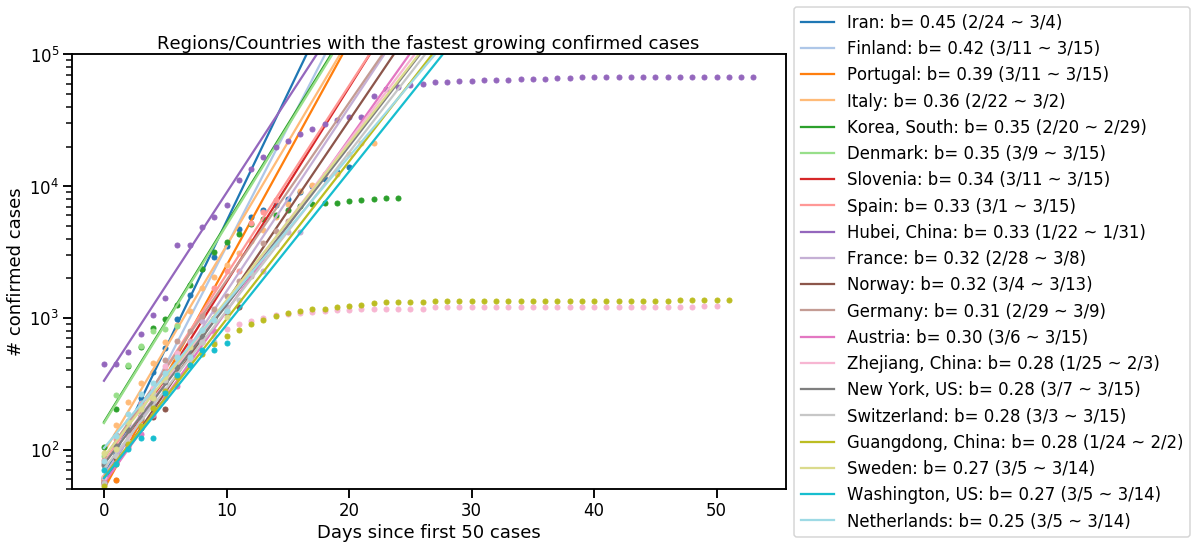

In [42]:
fig, ax = plt.subplots(figsize=(16, 8))

i = 0
for region, row in fitted_exp_params_df_max.head(20).iterrows():
    c = plt.cm.tab20.colors[i]
    
    n_confirmed = covid_df.loc[region, date_cols]

    a, b, n_data_points = row['a'], row['b'], row['n_data_points']
#     x = np.arange(n_data_points)
    x = np.arange(30)
    date0_with_100 = n_confirmed[n_confirmed > y_min].index[0][:-3]
    datet_with_100 = n_confirmed[n_confirmed > y_min].index[n_data_points-1][:-3]
        
    ax.plot(n_confirmed[n_confirmed>y_min].values, 
            color=c, 
            marker='o',
            ls='none',
            markersize=5
              )
    ax.plot(x, f_exponetial(x, a, b), color=c,
             label='%s: b=%5.2f (%s ~ %s)' % (region, b, date0_with_100, datet_with_100)
           )
    
    i += 1

ax.set_yscale('log')
ax.set_ylim([50, 1e5])
ax.set(title='Regions/Countries with the fastest growing confirmed cases',
       ylabel='# confirmed cases',
       xlabel='Days since first %d cases' % y_min
      )

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

fig.savefig('figs/top_regions_fastest_growth.png', 
           bbox_extra_artists=(lgd,), bbox_inches='tight')

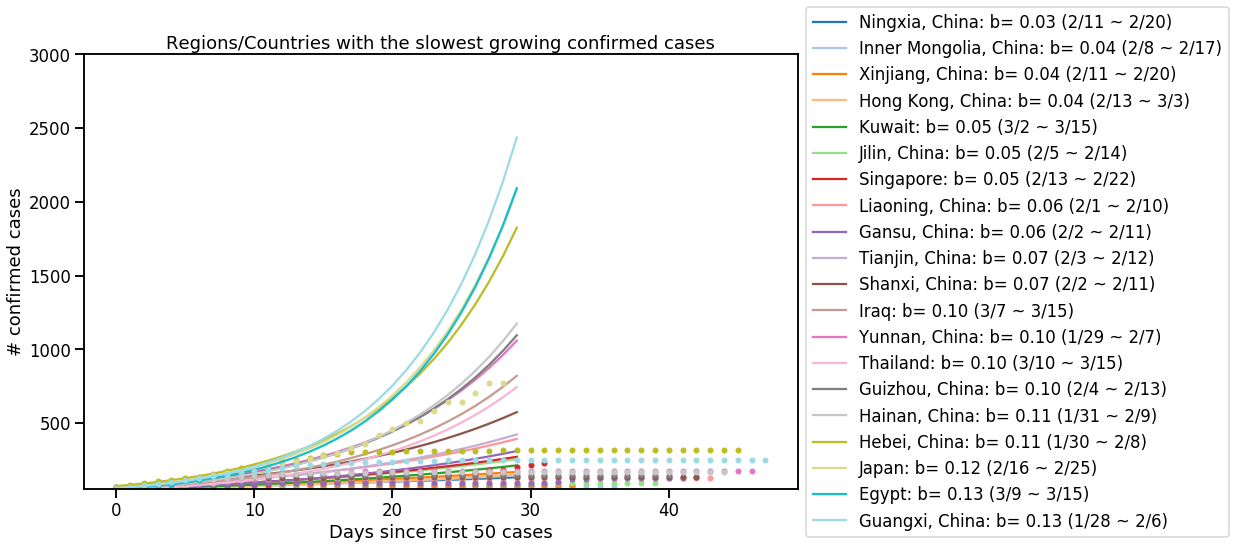

In [69]:
fig, ax = plt.subplots(figsize=(16, 8))

i = 0
for region, row in fitted_exp_params_df_max.query('n_data_points > 6').tail(20).iloc[::-1].iterrows():
    c = plt.cm.tab20.colors[i]
    
    n_confirmed = covid_df.loc[region, date_cols]

    a, b, n_data_points = row['a'], row['b'], row['n_data_points']
#     x = np.arange(n_data_points)
    x = np.arange(30)
    n_data_avail = len(n_confirmed[n_confirmed > y_min])
    
    date0_with_100 = n_confirmed[n_confirmed > y_min].index[0][:-3]
    datet_with_100 = n_confirmed[n_confirmed > y_min].index[min(n_data_points-1, n_data_avail-1)][:-3]
        
    ax.plot(n_confirmed[n_confirmed>y_min].values, 
            color=c, 
            marker='o',
            ls='none',
            markersize=5
              )
    ax.plot(x, f_exponetial(x, a, b), color=c,
             label='%s: b=%5.2f (%s ~ %s)' % (region, b, date0_with_100, datet_with_100)
#             label='%s: b=%5.2f, n=%d' % (region, b, n_data_points)
           )
    
    i += 1

ax.set_yscale('log')
ax.set_ylim([50, 3e3])
ax.set(title='Regions/Countries with the slowest growing confirmed cases',
       ylabel='# confirmed cases',
       xlabel='Days since first %d cases' % y_min
      )

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

fig.savefig('figs/bottom_regions_fastest_growth.png', 
           bbox_extra_artists=(lgd,), bbox_inches='tight')

In [67]:
min(n_data_points-1, n_data_avail)

6

## Normalize by population

In [43]:
covid_df_n_pop = covid_df.loc[shared_regions, date_cols].transpose() * 1e6 / \
    meta_df.loc[shared_regions, 'population']
covid_df_n_pop = covid_df_n_pop.transpose()\
    .sort_values(date_cols[-1], ascending=False)
covid_df_n_pop.index.name = 'region'

covid_df_n_pop[[date_cols[-1]]].rename(columns={date_cols[-1]: 'Cases per 1M on %s' % date_cols[-1]})

,Cases per 1M on 3/15/20
region,
San Marino,2723.101968
"Hubei, China",1148.661471
Iceland,455.350224
Italy,350.100129
Switzerland,258.320776
...,...
Congo (Kinshasa),0.023790
Kenya,0.019458
Nigeria,0.010211


In [44]:
top_countries = covid_df_n_pop.head(20).index

In [45]:
# melt
covid_df_n_pop_m = covid_df_n_pop\
    .iloc[:20]\
    .reset_index().melt(value_vars=date_cols, 
                           id_vars='region', 
                           value_name='n_confirmed',
                          var_name='date')
covid_df_n_pop_m['date'] = pd.to_datetime(covid_df_n_pop_m['date'])
covid_df_n_pop_m.head()

,region,date,n_confirmed
0,San Marino,2020-01-22,0.000000
1,"Hubei, China",2020-01-22,7.522874
2,Iceland,2020-01-22,0.000000
3,Italy,2020-01-22,0.000000
4,Switzerland,2020-01-22,0.000000


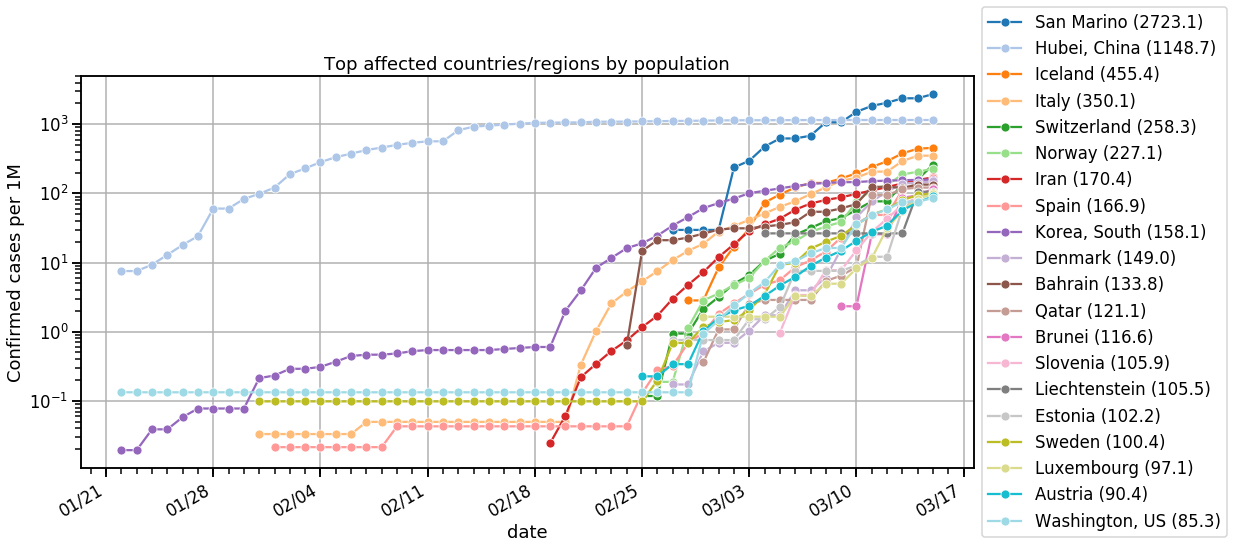

In [46]:
fig, ax = plt.subplots(figsize=(16, 8))
ax = sns.lineplot(x='date', 
                  y='n_confirmed',
                  hue='region',
                  hue_order=covid_df_n_pop.index[:20],
                  data=covid_df_n_pop_m.query('n_confirmed > 1e-2'),
                  marker='o',
                  ax=ax
                 )

top_countries_labels = ['%s (%.1f)' % (country, num)
    for country, num \
    in zip(covid_df_n_pop.index[:20], covid_df_n_pop[date_cols[-1]])]

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
lgd = ax.legend(
    labels=top_countries_labels, 
    loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_yscale('log')
ax.set_ylabel('Confirmed cases per 1M')
ax.set_title('Top affected countries/regions by population')

weeks = mdates.WeekdayLocator()
days = mdates.DayLocator()
week_fmt = mdates.DateFormatter('%m/%d')

# format the ticks
ax.xaxis.set_major_locator(weeks)
ax.xaxis.set_major_formatter(week_fmt)
ax.xaxis.set_minor_locator(days)

ax.grid(True)

fig.autofmt_xdate()
fig.savefig('figs/top_regions_n_pop.png', 
           bbox_extra_artists=(lgd,), bbox_inches='tight')

## Normalize by area

In [47]:
covid_df_n_area = covid_df.loc[shared_regions, date_cols].transpose() * 100 / \
    meta_df.loc[shared_regions, 'area']
covid_df_n_area = covid_df_n_area.transpose()\
    .sort_values(date_cols[-1], ascending=False)
covid_df_n_area.index.name = 'region'

covid_df_n_area[[date_cols[-1]]].rename(columns={date_cols[-1]: 'Cases per km^2 on %s' % date_cols[-1]})

,Cases per km^2 on 3/15/20
region,
San Marino,153.333333
"Hubei, China",36.467994
"Macau, China",32.786885
Singapore,31.432545
Bahrain,26.992287
...,...
"West Virginia, US",0.000000
Sudan,NaN
Monaco,NaN


In [48]:
# melt
covid_df_n_area_m = covid_df_n_area\
    .iloc[:20]\
    .reset_index().melt(value_vars=date_cols, 
                           id_vars='region', 
                           value_name='n_confirmed',
                          var_name='date')
covid_df_n_area_m['date'] = pd.to_datetime(covid_df_n_area_m['date'])
covid_df_n_area_m.head()

,region,date,n_confirmed
0,San Marino,2020-01-22,0.000000
1,"Hubei, China",2020-01-22,0.238838
2,"Macau, China",2020-01-22,3.278689
3,Singapore,2020-01-22,0.000000
4,Bahrain,2020-01-22,0.000000


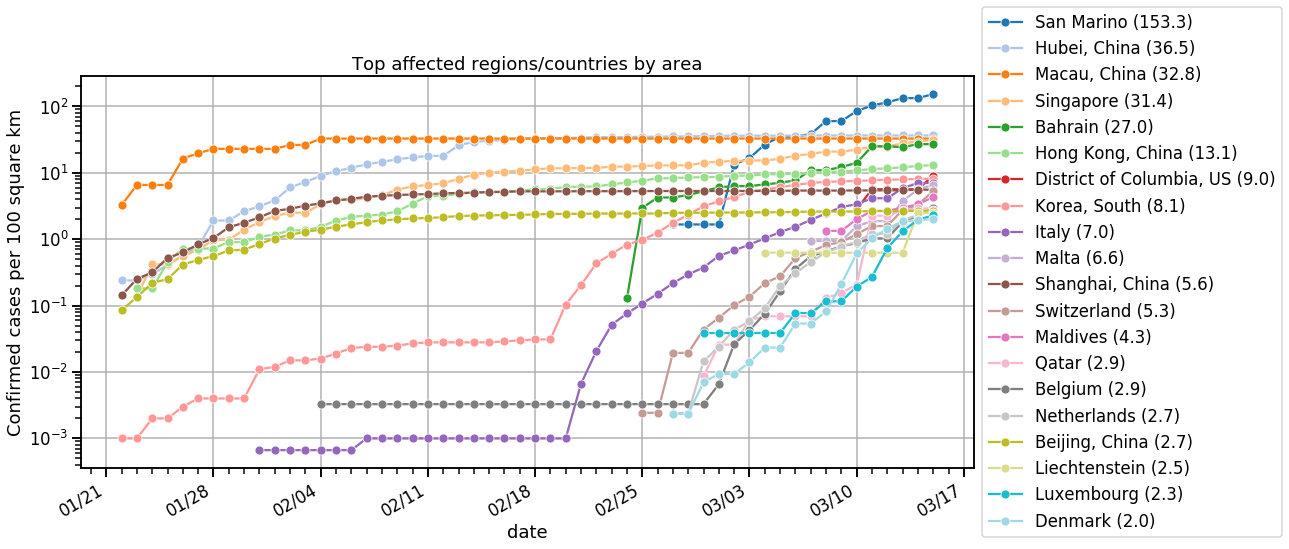

In [49]:
fig, ax = plt.subplots(figsize=(16, 8))
ax = sns.lineplot(x='date', 
                  y='n_confirmed',
                  hue='region',
                  hue_order=covid_df_n_area.index[:20],
                  data=covid_df_n_area_m.query('n_confirmed > 1e-4'),
                  marker='o',
                  ax=ax
                 )

top_countries_labels = ['%s (%.1f)' % (country, num)
    for country, num \
    in zip(covid_df_n_area.index[:20], covid_df_n_area[date_cols[-1]])]

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
lgd = ax.legend(
    labels=top_countries_labels, 
    loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_yscale('log')
ax.set_ylabel('Confirmed cases per 100 square km')
ax.set_title('Top affected regions/countries by area')

weeks = mdates.WeekdayLocator()
days = mdates.DayLocator()
week_fmt = mdates.DateFormatter('%m/%d')

# format the ticks
ax.xaxis.set_major_locator(weeks)
ax.xaxis.set_major_formatter(week_fmt)
ax.xaxis.set_minor_locator(days)

ax.grid(True)

fig.autofmt_xdate()
fig.savefig('figs/top_regions_n_area.png', 
           bbox_extra_artists=(lgd,), bbox_inches='tight')